# Thesis Prototype
Jack Michake Crookes </br>
BAN 6-3A </br>
0116506L </br>

## Data Preprocessing

### Data Loading
*Import the transactional logs into a DataFrame.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/osrs_Coal.csv')

df.head()

,id,price,volume,timestamp
0,453,138,NaN,1.427500e+12
1,453,142,NaN,1.427590e+12
2,453,147,NaN,1.427670e+12
3,453,142,NaN,1.427760e+12
4,453,139,NaN,1.427850e+12


### Feature Engineering
*Extract useful features such as item types, sales trends, time-related features (day of the week, month, seasonality).*

In [3]:
# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Assuming timestamp is in milliseconds

# Set the timestamp as the index (if time series data)
df.set_index('timestamp', inplace=True)

# Replace NaN values in the 'volume' column with zeros
df['volume'] = df['volume'].fillna(0)

# Extract time-related features
df['day_of_week'] = df.index.dayofweek  # Monday is 0, Sunday is 6
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_year'] = df.index.dayofyear

# Rolling features (e.g., 7-day moving average)
df['price_7d_ma'] = df['price'].rolling(window=7).mean()
df['volume_7d_ma'] = df['volume'].rolling(window=7).mean()

# Lag features (e.g., 1-day lag)
df['price_lag_1d'] = df['price'].shift(1)
df['volume_lag_1d'] = df['volume'].shift(1)

# Change features (e.g., daily price change)
df['price_change'] = df['price'].pct_change()

# Handle missing values (if necessary, e.g., after rolling and shift operations)
df.fillna(method='bfill', inplace=True)  # Backfill with the next valid observation

# Take data from 2019 onwards
df = df.loc['2019':]

# Display the resulting DataFrame
df.head(5000)

,id,price,volume,day_of_week,month,year,day_of_year,price_7d_ma,volume_7d_ma,price_lag_1d,volume_lag_1d,price_change
timestamp,,,,,,,,,,,,
2019-01-02 00:46:40,453,265,41927138.0,2,1,2019,2,268.571429,4.056758e+07,279.0,21308892.0,-0.050179
2019-01-02 23:00:00,453,251,32289134.0,2,1,2019,2,268.285714,3.574923e+07,265.0,41927138.0,-0.052830
2019-01-04 00:00:00,453,238,30232332.0,4,1,2019,4,265.714286,3.726622e+07,251.0,32289134.0,-0.051793
2019-01-05 01:00:00,453,230,54848789.0,5,1,2019,5,260.428571,3.680417e+07,238.0,30232332.0,-0.033613
2019-01-05 23:13:20,453,226,11019263.0,5,1,2019,5,253.000000,3.412829e+07,230.0,54848789.0,-0.017391
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-22 15:33:20,453,153,50884569.0,0,4,2024,113,151.142857,5.955800e+07,151.0,96067445.0,0.013245
2024-04-23 08:13:20,453,153,46519308.0,1,4,2024,114,151.428571,5.716459e+07,153.0,50884569.0,0.000000
2024-04-24 09:13:20,453,155,57522699.0,2,4,2024,115,152.142857,5.795473e+07,153.0,46519308.0,0.013072


### Time Aggregation
*Aggregate data at an appropriate time interval, like daily or weekly sales, depending on the data structure and sales pattern.*

In [4]:
# Aggregate by week, summing up volumes and taking the last available price for each week
weekly_aggregated = df.resample('W').agg({
    'price': 'last',  # Use the last available price for the week
    'volume': 'sum',  # Sum up the weekly volume
    'day_of_week': 'last',
    'month': 'last',
    'year': 'last',
    'day_of_year': 'last'
})

# Reset index to make timestamp an explicit column again
weekly_aggregated.reset_index(inplace=True)

print(weekly_aggregated.head())

   timestamp  price       volume  day_of_week  month    year  day_of_year
0 2019-01-06  226.0  170316656.0          5.0    1.0  2019.0          5.0
1 2019-01-13  219.0  201698056.0          6.0    1.0  2019.0         13.0
2 2019-01-20  229.0  224352672.0          5.0    1.0  2019.0         19.0
3 2019-01-27  220.0  291850579.0          6.0    1.0  2019.0         27.0
4 2019-02-03  212.0  256186628.0          5.0    2.0  2019.0         33.0


In [5]:
weekly_aggregated = weekly_aggregated.dropna()

In [6]:
missing_per_column = weekly_aggregated.isnull().sum()
print(missing_per_column)

timestamp      0
price          0
volume         0
day_of_week    0
month          0
year           0
day_of_year    0
dtype: int64


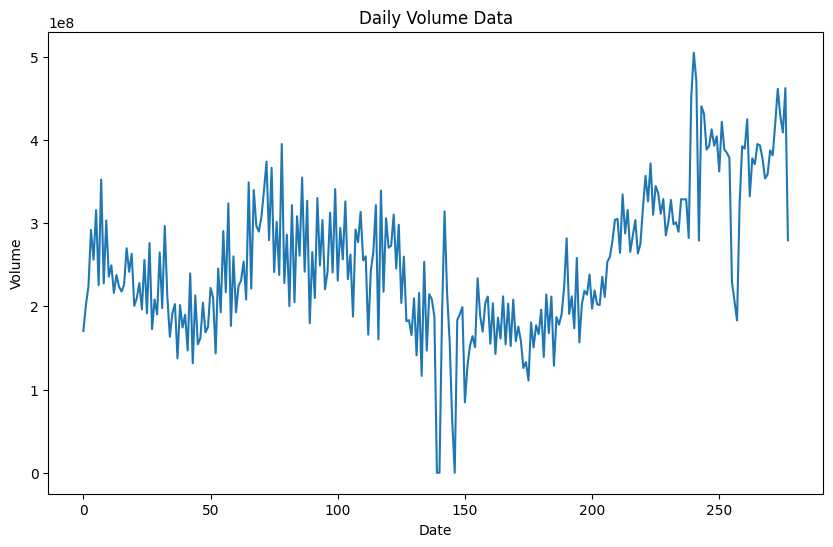

In [7]:
import matplotlib.pyplot as plt

# Plot the daily data
weekly_aggregated['volume'].plot(figsize=(10, 6), title='Daily Volume Data')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

## Exploratory Data Analysis (EDA)
*Visualize sales trends over time to identify seasonality, trends, and outliers.* </br>
*Check for missing data or outliers that could affect modeling and handle them appropriately.*

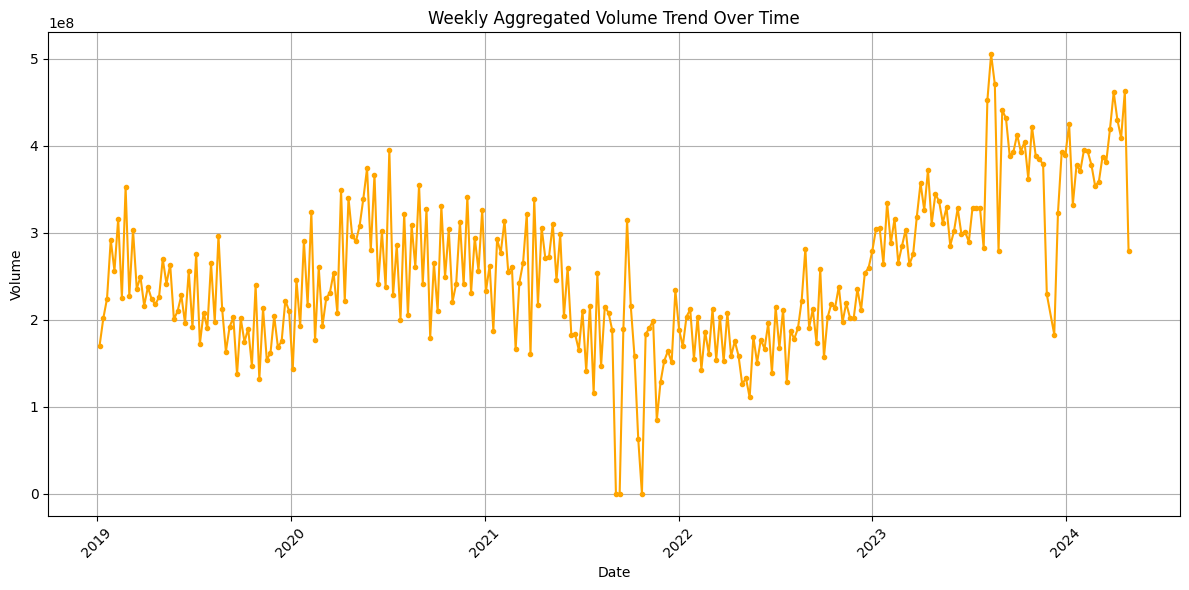

In [8]:
# Visualize the trend over time
import matplotlib.pyplot as plt

# Plot the volume trend over time
plt.figure(figsize=(12, 6))
plt.plot(weekly_aggregated['timestamp'], weekly_aggregated['volume'], marker='.', linestyle='-', color='orange')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Weekly Aggregated Volume Trend Over Time')
plt.grid(True)  # Add grid for easier trend observation
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

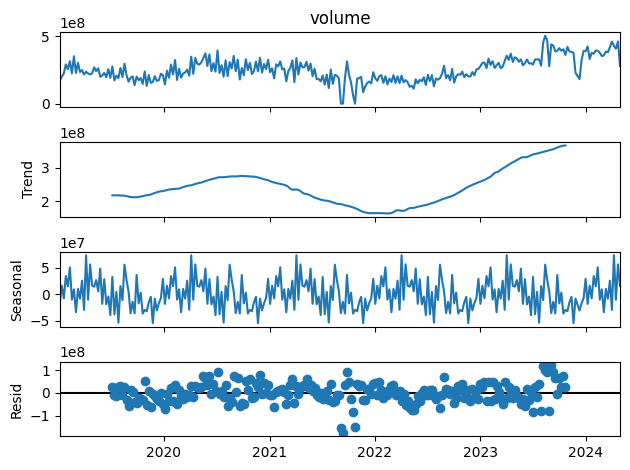

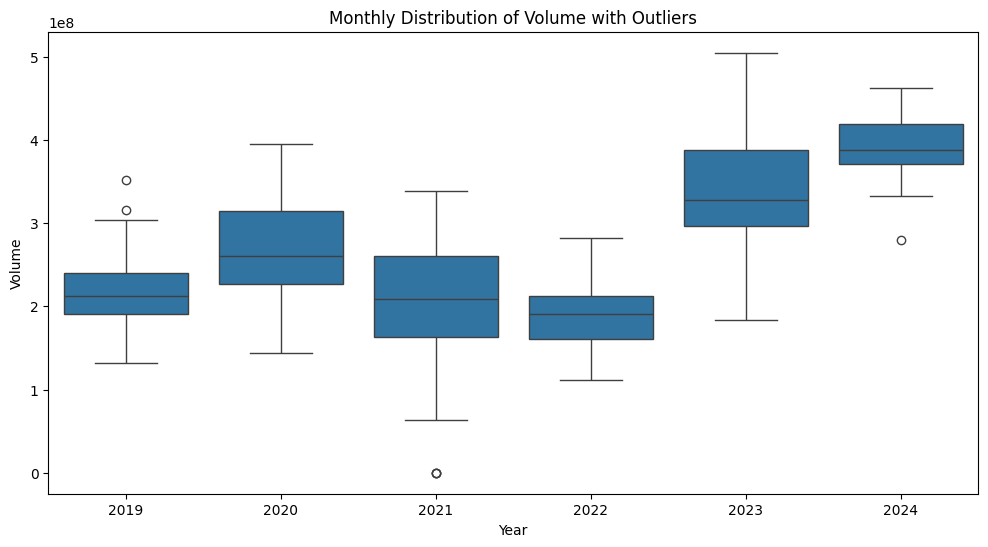

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonality Detection through Decomposition
# Ensure the timestamp column is the index and it's a datetime index
weekly_aggregated.set_index('timestamp', inplace=True)

# Decompose the time series data
result = seasonal_decompose(weekly_aggregated['volume'], model='additive', period=52)  # Assuming weekly data, 52 weeks/year

# Plot the decomposition results
result.plot()
plt.show()

# Outliers Detection through Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x=weekly_aggregated.index.year, y=weekly_aggregated['volume'])
plt.xlabel('Year')
plt.ylabel('Volume')
plt.title('Monthly Distribution of Volume with Outliers')
plt.show()

## Train-Test Split
*Split the dataset into a training and a testing set. Consider a rolling window or time-based split to ensure that future data is unseen.*

In [10]:
from sklearn.model_selection import train_test_split

# Assuming your data is not shuffled and in time series order
# Specify features and target (assuming 'volume' is the target in this case)
X = weekly_aggregated.drop(columns=['volume'])
y = weekly_aggregated['volume']

# Perform the split, ensuring that shuffle is False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Combine back to form train and test sets if necessary
train_data = X_train.copy()
train_data['volume'] = y_train

test_data = X_test.copy()
test_data['volume'] = y_test

# Display the sizes to verify the split
print(f'Training data size: {train_data.shape[0]}')
print(f'Test data size: {test_data.shape[0]}')

Training data size: 193
Test data size: 84


## Model Building and Evaluation

### XGBoost & Random Forest
**Feature preparation**: Create lag features or other relevant features for the models. </br>
**Training**: Perform grid search for hyperparameter tuning.</br>
**Evaluation**: Use cross-validation over a rolling window.</br>

In [11]:
# XGBoost
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Define the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Custom RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Initialize TimeSeriesSplit for cross-validation (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=2)

# Perform grid search with time series split
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=rmse_scorer, cv=tscv, verbose=1)
grid_search.fit(X, y)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score: ", grid_search.best_score_)

Fitting 2 folds for each of 2000 candidates, totalling 4000 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 250, 'subsample': 1.0}
Best RMSE score:  140016706.3791399


In [12]:
# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

# Predict on the training set or another validation set (depending on your strategy)
predictions = best_model.predict(X)

# Calculate evaluation metrics
rmse = mean_squared_error(y, predictions, squared=False)
mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 6714389.3191810325
MAE: 4552727.0613718415
R²: 0.993809435824424


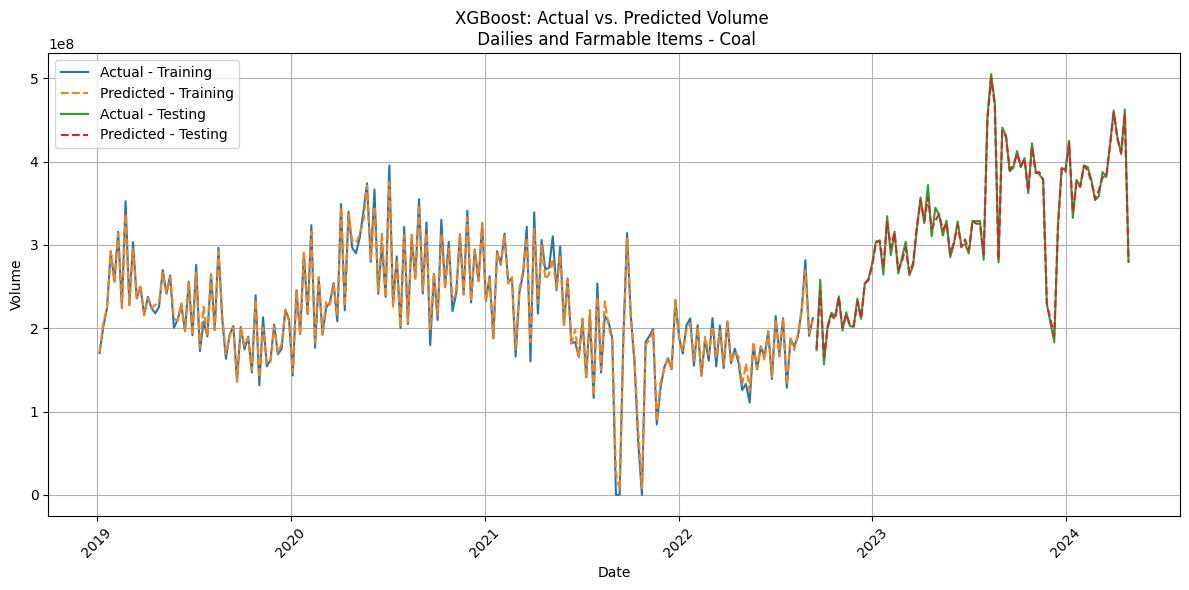

In [13]:
import matplotlib.pyplot as plt

# Assuming best_model is the best estimator from the grid search
# Make predictions using the best model on the training data
predictions_train = best_model.predict(X_train)

# Optionally, also predict on test data if it exists
predictions_test = best_model.predict(X_test)

# Plot the actual vs. predicted values for the training data
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, y_train, label='Actual - Training')
plt.plot(X_train.index, predictions_train, label='Predicted - Training', linestyle='--')

# Plot the actual vs. predicted values for the test data
plt.plot(X_test.index, y_test, label='Actual - Testing')
plt.plot(X_test.index, predictions_test, label='Predicted - Testing', linestyle='--')

# Add titles, legend, and labels
plt.title('XGBoost: Actual vs. Predicted Volume \n Dailies and Farmable Items - Coal')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [14]:
# Import necessary libraries
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Define the RandomForestRegressor model
model = RandomForestRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Custom RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Initialize TimeSeriesSplit for cross-validation (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=2)

# Perform grid search with time series split
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=rmse_scorer, cv=tscv, verbose=1)
grid_search.fit(X, y)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score: ", grid_search.best_score_)

Fitting 2 folds for each of 675 candidates, totalling 1350 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters found:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE score:  131531463.79314804


In [15]:
# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

# Predict on the training set or another validation set (depending on your strategy)
predictions = best_model.predict(X)

# Calculate evaluation metrics
rmse = mean_squared_error(y, predictions, squared=False)
mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 36705334.157294825
MAE: 26525302.327260155
R²: 0.8149983695516951


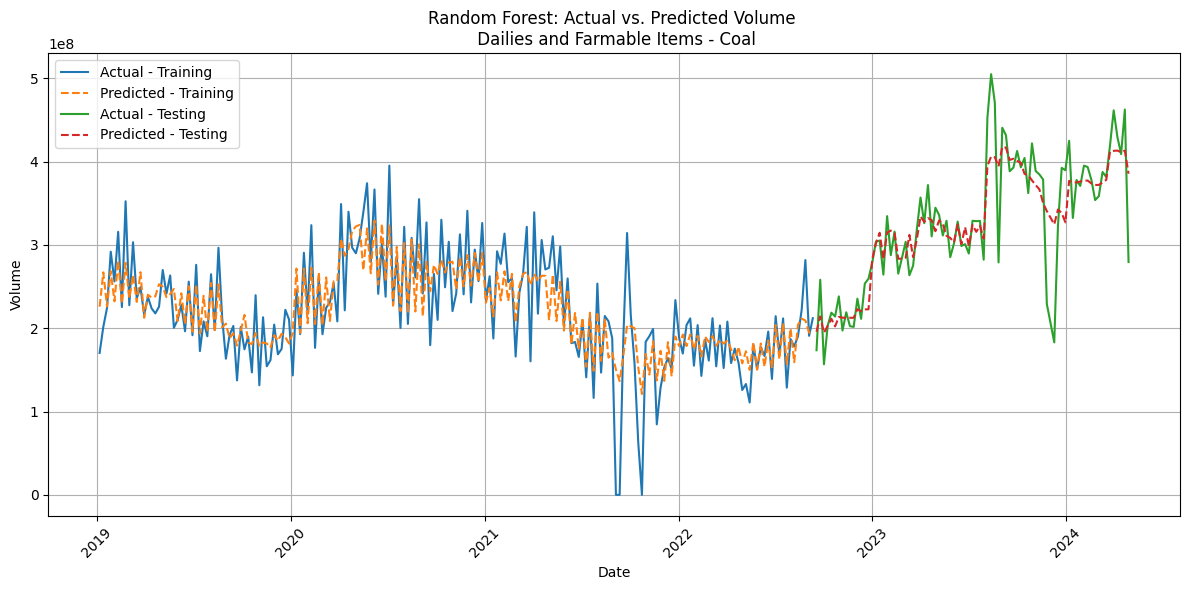

In [16]:
import matplotlib.pyplot as plt

# Assuming best_model is the best estimator from the grid search
# Make predictions using the best model on the training data
predictions_train = best_model.predict(X_train)

# Optionally, also predict on test data if it exists
predictions_test = best_model.predict(X_test)

# Plot the actual vs. predicted values for the training data
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, y_train, label='Actual - Training')
plt.plot(X_train.index, predictions_train, label='Predicted - Training', linestyle='--')

# Plot the actual vs. predicted values for the test data
plt.plot(X_test.index, y_test, label='Actual - Testing')
plt.plot(X_test.index, predictions_test, label='Predicted - Testing', linestyle='--')

# Add titles, legend, and labels
plt.title('Random Forest: Actual vs. Predicted Volume \n Dailies and Farmable Items - Coal')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

### LSTM
**Feature preparation**: Convert the time series data into supervised learning form using a sliding window approach.</br>
**Architecture**: Set up the LSTM architecture with appropriate layers and units.</br>
**Training**: Train and evaluate the model using a rolling window for validation.</br>

### Data Normalization

In [17]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras_tuner import RandomSearch

# Custom RMSE Metric
def root_mean_squared_error(y_true, y_pred):
    return tf.math.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))

# Example data load
# Assume df_monthly is your DataFrame containing the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weekly_aggregated[['volume']].values)  # Replace 'feature_column' with your actual data column

# Function to create the dataset with sequences
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 5
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM [samples, time steps, features]

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model definition with the Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=True,
                   input_shape=(time_step, 1)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',
                  metrics=['mean_absolute_error', root_mean_squared_error])
    return model

# Set up Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_lstm'
)

# Perform hyperparameter search
tuner.search(X_train, y_train,
             epochs=250,
             batch_size=64,
             validation_data=(X_test, y_test),
             verbose=1)

# Get the best model and fit it with the training data
best_model = tuner.get_best_models(num_models=1)[0]
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the best model
history = best_model.fit(X_train, y_train, epochs=250, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Evaluate the model using the unscaled RMSE and MAE
# Generate predictions for test set
predictions_test_scaled = best_model.predict(X_test)

# Inverse transform the scaled predictions to original scale
predictions_test = scaler.inverse_transform(predictions_test_scaled)

# Inverse transform the actual scaled test labels to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate RMSE, MAE, and R² on the original scale
rmse_original = np.sqrt(mean_squared_error(y_test_original, predictions_test))
mae_original = mean_absolute_error(y_test_original, predictions_test)
r2_original = r2_score(y_test_original, predictions_test)

print(f'Test RMSE on original scale: {rmse_original}')
print(f'Test MAE on original scale: {mae_original}')
print(f'Test R² on original scale: {r2_original}')

Trial 10 Complete [00h 00m 45s]
val_loss: 0.010724869556725025

Best val_loss So Far: 0.010724869556725025
Total elapsed time: 00h 16m 57s
Epoch 1/250
3/3 [==============================] - 4s 455ms/step - loss: 0.0176 - mean_absolute_error: 0.0998 - root_mean_squared_error: 0.1324 - val_loss: 0.0107 - val_mean_absolute_error: 0.0789 - val_root_mean_squared_error: 0.1121
Epoch 2/250
3/3 [==============================] - 0s 33ms/step - loss: 0.0159 - mean_absolute_error: 0.0967 - root_mean_squared_error: 0.1260 - val_loss: 0.0107 - val_mean_absolute_error: 0.0786 - val_root_mean_squared_error: 0.1118
Epoch 3/250
3/3 [==============================] - 0s 31ms/step - loss: 0.0166 - mean_absolute_error: 0.0954 - root_mean_squared_error: 0.1284 - val_loss: 0.0107 - val_mean_absolute_error: 0.0785 - val_root_mean_squared_error: 0.1117
Epoch 4/250
3/3 [==============================] - 0s 27ms/step - loss: 0.0166 - mean_absolute_error: 0.0966 - root_mean_squared_error: 0.1289 - val_loss: 0.0

3/3 [==============================] - 0s 5ms/step


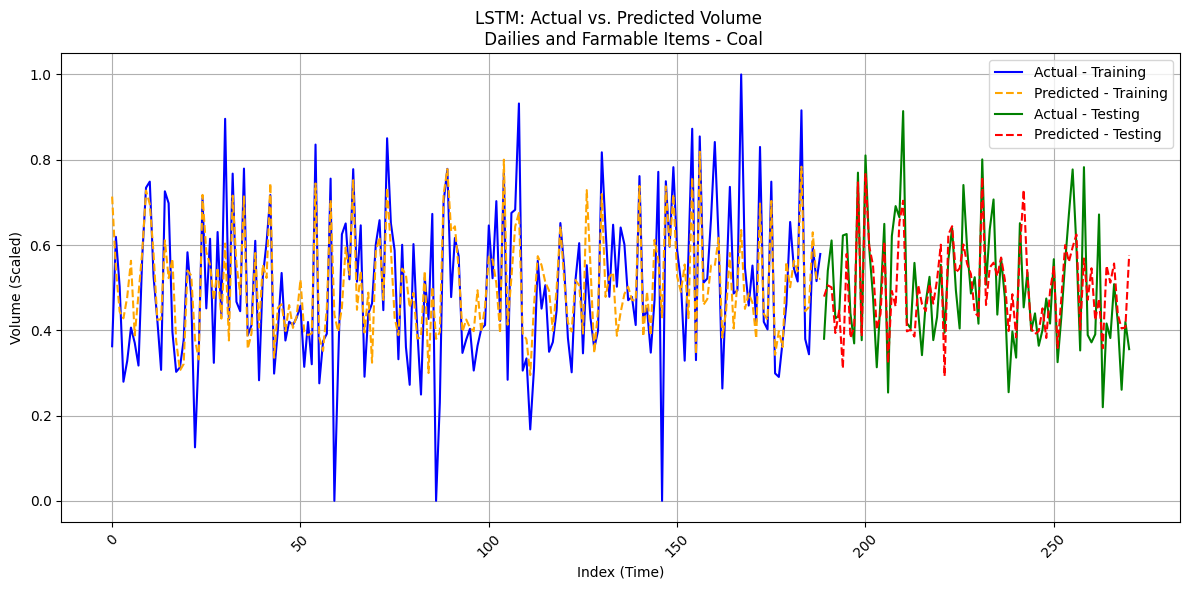

In [19]:
import matplotlib.pyplot as plt

# Generate predictions
predictions_train = best_model.predict(X_train)
predictions_test = best_model.predict(X_test)

# Handling the index for plotting since the original dataset index was lost during the dataset creation
# You might want to adjust this if your 'weekly_aggregated' DataFrame has a specific datetime index you want to use
train_index = np.arange(len(y_train))
test_index = np.arange(len(y_train), len(y_train) + len(y_test))

# Plotting
plt.figure(figsize=(12, 6))

# Since X_train and X_test are not DataFrame and have no index, we generate index based on length
plt.plot(train_index, y_train, label='Actual - Training', color='blue')
plt.plot(train_index, predictions_train, label='Predicted - Training', linestyle='--', color='orange')

plt.plot(test_index, y_test, label='Actual - Testing', color='green')
plt.plot(test_index, predictions_test, label='Predicted - Testing', linestyle='--', color='red')

# Adding titles, labels, and legend
plt.title('LSTM: Actual vs. Predicted Volume \n Dailies and Farmable Items - Coal')
plt.xlabel('Index (Time)')
plt.ylabel('Volume (Scaled)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Adjust this if you are using actual dates and they overlap
plt.tight_layout()

# Show the plot
plt.show()